<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [36]:
%%capture
pip install pyswarms

In [37]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [38]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'
DIAS_OBSERVADOS = 600

In [39]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [40]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [41]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [42]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [43]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - math.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [44]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [45]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [46]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [47]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [48]:
# Defina o dicionário de tipos de dados
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario01.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario02.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario03.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario04.csv.csv', sep=";")
df = pd.read_csv('/content/drive/MyDrive/datasets/cenario01.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0


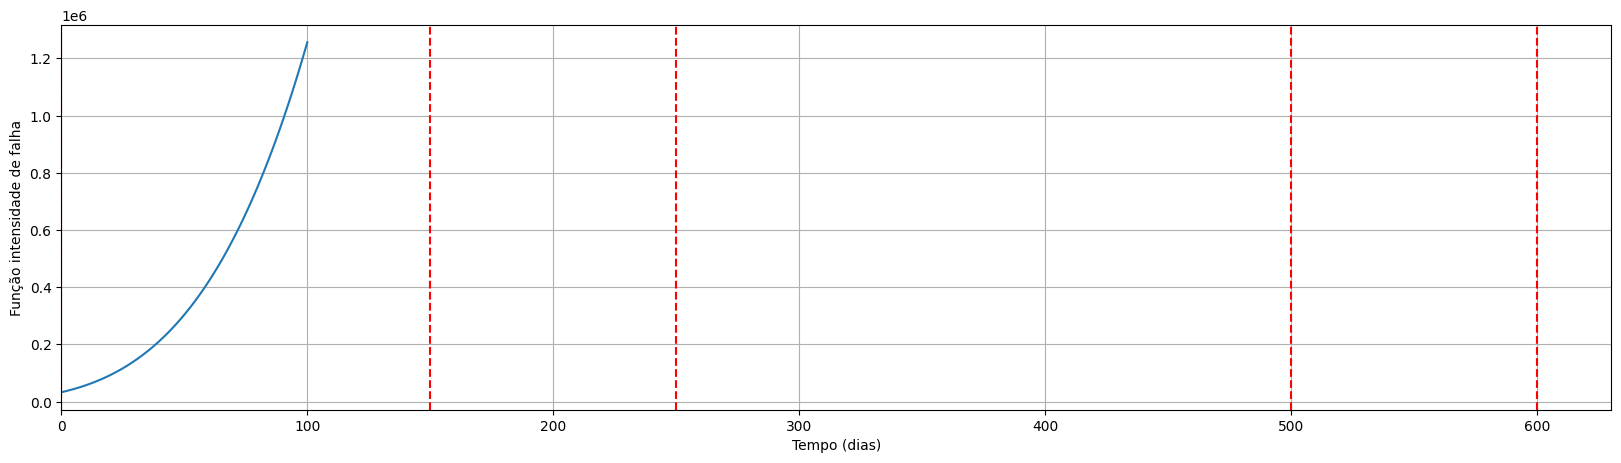

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [49]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [50]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [51]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-09-30 16:02:21,399 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   9%|▉         |9/100, best_cost=4.74e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 8, 85, 189, 271, 325, 335, 490, 557, 616, 635]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 10.48576, 1212836.9491980046, 10208608.557191148, 19612218.06721125, 43905042.58159889, 47769097.84083005, 572307608.1319165, 621862282.4734418, 2362879121.164279, 2377172899.786858, 1349450080.9329464]
Custo =  259206065624.40363


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 80, 133, 202, 217, 394, 441, 520, 568, 579, 630, 700]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.329679

pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=4.35e+10

Custo =  49303774094.773254


Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 28, 42, 65, 104, 149, 156, 194, 227, 274, 324, 382, 405, 443, 462, 490, 586, 610, 714]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 5507.317760000001, 16853.01491648, 43467.033507252025, 183562.21500186014, 653741.724895562, 784187.2959226234, 11484664.441232001, 29111625.601233207, 39927669.21250044, 61551869.563876666, 309528549.4422096, 329412786.1908289, 338638258.

pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=4.03e+10

Custo =  103287819658.9224


Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 22, 48, 78, 117, 191, 294, 324, 352, 388, 393, 440, 477, 537, 588, 619, 654, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1649.16224, 37370.29972363454, 115496.26904302224, 297671.319540482, 3510823.718471193, 52932111.283772185, 64302816.972703084, 153068315.2443203, 181140804.8650023, 184702518.7111462, 197228293.8719341, 261202078.9948737, 439647657.512662, 1694232481.9784813, 1838743656.

pyswarms.single.global_best:  57%|█████▋    |57/100, best_cost=3.66e+10


Custo =  197703089448.84427


Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 41, 73, 116, 149, 152, 189, 232, 258, 285, 324, 381, 441, 457, 484, 572, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 37073.98432, 270353.66069919075, 504410.90636018885, 727211.855251665, 775553.7582673617, 10161312.07424234, 34972748.41989272, 39000835.953084655, 45153903.453848235, 60807323.585756555, 302122577.7910304, 387627928.0716926, 390946097.1243321, 438471124.9596068, 2328844241.5911326, 2808883287.77

pyswarms.single.global_best:  57%|█████▋    |57/100, best_cost=3.66e+10<ipython-input-50-3f464f4b430c>:86: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))
pyswarms.single.global_best:  71%|███████   |71/100, best_cost=3.66e+10

Custo =  75707300648.33398


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 23, 42, 76, 119, 192, 232, 242, 323, 383, 440, 475, 535, 581]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2059.6297600000003, 17234.779218967422, 111581.6268411611, 359092.9485647275, 3483905.651946501, 8224923.604491111, 9297547.951800859, 52979236.64280305, 103917193.22934178, 183278228.9399764, 193765466.6632293, 369720896.5323422, 1452293002.8952408, 1528066295.305859]
Custo =  135252114316.06075


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 26, 41, 74, 119, 

pyswarms.single.global_best:  78%|███████▊  |78/100, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 41, 72, 117, 149, 153, 193, 232, 324, 383, 407, 442, 583, 601, 693]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 37073.98432, 250985.27537757828, 522364.9418383778, 730449.2374741475, 797295.5938329359, 11811848.268568357, 34399841.863634914, 89091895.40373805, 138884797.4349504, 160129824.2941805, 168241000.8642824, 957293321.8543409, 1029355106.7090917, 1204565787.85498, -1791391709.135079]
Custo =  188662343179.85434


Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [

pyswarms.single.global_best:  93%|█████████▎|93/100, best_cost=3.66e+10

 62971000637.22206


Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 42, 77, 118, 148, 151, 190, 232, 252, 293, 323, 348, 382, 441, 495, 572, 702]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 41821.194240000004, 357627.3535256223, 570480.6388744453, 747909.6201271263, 795001.5265547049, 10884604.124620719, 35139892.84381644, 37842965.46554502, 49325859.29834482, 60563259.788182504, 136568545.7575215, 161292930.69939965, 244956658.66408288, 268312093.6920396, 577906197.1972198, 930260618.0715442, 

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.66e+10
2023-09-30 16:02:22,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041938 5.37629693 5.60807342 4.0268366  2.05748502 0.94202621
 3.24444883 3.74278131 0.13339988 5.63805965 3.78910955 4.66042838
 5.85464045 2.93199544 3.69706152 1.43275927 6.09649312 3.69495061
 6.25408816 5.75502707 0.35014656 3.65465969 3.51064299 6.76868211]
2023-09-30 16:02:22,896 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 42, 74, 115, 150, 194, 232, 323, 383, 441, 478, 493, 582, 668, 695]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 41821.194240000004, 288191.3985847138, 489137.90613987617, 748399.5581577541, 3655898.221027483, 25688221.02910562, 78815225.9469291, 129753182.53346781, 211593198.8826027, 223204039.10849476, 250415494.6077938, 2300049515.461877, 2438209498.6312575, 2468786573.755475, 2153431798.4094973]
Custo =  138906857480.51337


Número de ciclos de manutenção: 16 5
Tempos para manutenções prevent

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:22,928 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70056061 5.37629772 5.60807252 4.02684561 2.05726653 0.94202307
 3.2444412  3.74286471 0.13337642 5.63682214 3.7890841  4.66043683
 5.85464309 2.93200506 3.69717897 1.43275846 6.09637421 3.69499643
 6.25195313 5.75386637 0.34925712 3.65466396 3.49564547 6.76852554]
2023-09-30 16:02:22,933 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 21 5
Tempos para manutenções preventivas: [0, 29, 43, 76, 116, 150, 197, 232, 299, 323, 354, 384, 398, 441, 459, 502, 523, 589, 620, 633, 684, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 6563.56768, 19054.62427528631, 107470.86215937199, 298853.43089837406, 541553.4588521343, 3942498.405728215, 24306867.65455887, 49120090.824623436, 57790600.26479243, 60890853.91

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:22,968 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70058632 5.37630147 5.60807218 4.02687149 2.05736381 0.94202176
 3.24441467 3.74296    0.13333643 5.63689479 3.78907486 4.66044387
 5.85464365 2.93201866 3.69719636 1.43276641 6.09646548 3.69502848
 6.24994641 5.75419661 0.3494993  3.65465465 3.47117423 6.76863815]
2023-09-30 16:02:22,970 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 24, 43, 77, 118, 195, 232, 249, 323, 352, 385, 400, 441, 452, 504, 517, 590, 652, 715]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2548.0396800000003, 19221.779777039636, 117106.05181402294, 329959.337162846, 4095279.28590847, 8351722.822231705, 10496305.347514248, 48286996.45343378, 51039839.13363584, 75639997.81814213, 87571767.56341848, 97756431.47738983, 111718144.21451437, 229614185.98529133, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,000 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70058382 5.37630443 5.60807209 4.02688493 2.05746995 0.9420212
 3.24440002 3.74302571 0.13331195 5.63700747 3.78906798 4.66044928
 5.85464338 2.9320279  3.69720904 1.43277176 6.09655313 3.69504668
 6.24934647 5.75451054 0.34983018 3.65464719 3.45914452 6.76875062]
2023-09-30 16:02:23,002 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 19, 43, 79, 192, 232, 323, 358, 385, 401, 441, 507, 514, 591, 680]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 22094.99152159055, 141338.4329323975, 12311602.678139273, 13513888.441253588, 66640893.359077066, 86620922.22419864, 106155805.01138112, 119063024.39420357, 128871390.51220356, 291087086.987362, 305697518.60367274, 382167688.3110167, 1091104486.9086204, 1065979340.8206629]
Custo =  67559521016.70819


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,030 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70057903 5.37630679 5.60807228 4.02688702 2.05756656 0.94202115
 3.24439221 3.74307742 0.13329475 5.63716152 3.7890672  4.66045174
 5.85464286 2.93202763 3.6971897  1.43277551 6.09662231 3.69505735
 6.24882951 5.75494153 0.35014247 3.65464344 3.45689299 6.76883619]
2023-09-30 16:02:23,039 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 14, 43, 80, 189, 232, 323, 385, 401, 440, 511, 592, 697]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 172.10368000000003, 26812.99750696554, 158046.7633376731, 10667628.634278962, 12059193.293102624, 65186198.2109261, 119470553.54268305, 132377772.9255055, 141743389.82981184, 325308762.25916564, 700794927.942728, 1665296911.2063746, 1636402336.9735298]
Custo =  77376583483.9963


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 42, 80, 186, 232, 251, 323, 385, 398, 440, 593, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 51.53632, 26670.701018662916, 166002.1415808074, 9490173.773886051, 11092288.73718479, 13601995.035142362, 49810220.19481902, 322624693.84430754, 332678880.6906212, 343165594.00140005, 1297949743.2252874, 1797927213.334539, 1776199900.5374904]
Custo =  78817752084.32059


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,061 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70055566 5.37630668 5.60807254 4.02688359 2.05764332 0.94202187
 3.24439643 3.74311015 0.13329205 5.63754297 3.78907795 4.66045122
 5.85464224 2.93202495 3.69717091 1.43277656 6.09667491 3.69505485
 6.24994096 5.75534576 0.35042389 3.65464135 3.45916393 6.76888085]
2023-09-30 16:02:23,064 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,100 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70050494 5.37630642 5.60807287 4.02687549 2.05770256 0.94202263
 3.24440081 3.74305957 0.13329565 5.63793181 3.78909053 4.6604502
 5.85464153 2.93202059 3.69712831 1.43277486 6.09670146 3.69504592
 6.25169318 5.755



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 9, 41, 80, 184, 232, 242, 285, 323, 385, 393, 440, 513, 594, 615, 630]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 18.895680000000002, 25481.47840365973, 173297.94744513978, 8768492.274975345, 10523687.361410636, 11596311.708720384, 22643639.279118832, 37621492.28015687, 310435965.92964536, 316202447.94208246, 328728223.10287035, 521866446.4774983, 902067498.3392525, 994891049.930625, 1005476591.6193645, 130705482.7202419]
Custo =  191576640646.17206


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,133 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70044717 5.37630448 5.60807329 4.02686339 2.05769703 0.94202339
 3.24440627 3.74300877 0.13330179 5.63830487 3.78910725 4.66044919
 5.85464057 2.93201471 3.69707415 1.43277149 6.09668948 3.69501216
 6.25328001 5.75586929 0.3507827  3.65464662 3.47088886 6.76891743]
2023-09-30 16:02:23,137 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 40, 79, 182, 232, 291, 323, 386, 440, 453, 517, 594]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 21341.899705539257, 164219.60366678482, 8336603.543722637, 10255704.731899854, 28860692.287511352, 40997478.50333041, 97011482.52261655, 171100168.59168637, 173616747.13556495, 341372854.68177354, 2279732379.326607, 2302857570.1897464]
Custo =  139681247183.52222


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 14, 40, 78, 180, 232, 323, 333, 386, 440, 458, 523, 595, 617]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 172.10368000000003, 17899.455670885694, 147943.8485463313, 7914322.426798653, 10008739.757731128, 63135744.6755546, 66909453.011501156, 111363050.00544953, 127135763.27763176, 130989566.697791, 309603038.76382935, 2140024773.1708336, 2238787822.8533654, 2231149821.8605747]
Custo =  142142405241.34247


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,162 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70039373 5.37630212 5.60807369 4.02684689 2.05765541 0.94202448
 3.24441357 3.74295913 0.13331798 5.63862191 3.78912289 4.66044589
 5.8546397  2.93200488 3.69702324 1.43276593 6.09663227 3.69496523
 6.25479847 5.75587889 0.35075441 3.65465394 3.48751664 6.76888032]
2023-09-30 16:02:23,164 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 17, 39, 77, 180, 231, 271, 323, 335, 385, 440, 463, 531, 594, 644]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 454.35424000000006, 13684.72775960982, 139273.01384254312, 8161658.286750736, 10143114.177409612, 18482788.130602006, 41035849.07282502, 73002255.29038242, 113837993.09828156, 130114853.52474666, 135557004.2550156, 335733364.55133975, 1936016375.9975328, 2223292722.453836, 2206839175.3435717]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,195 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70035311 5.3762989  5.60807403 4.02683051 2.05756704 0.94202591
 3.24443023 3.74286992 0.13333497 5.63889977 3.78913332 4.66044177
 5.85463906 2.931994   3.69697779 1.43275909 6.09656651 3.69492171
 6.25597939 5.75574454 0.35063258 3.65466184 3.5083066  6.76879921]
2023-09-30 16:02:23,198 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  156962306452.28027


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 21, 39, 76, 181, 232, 323, 332, 385, 440, 467, 537, 594, 708]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 1306.9123200000001, 11996.794318657712, 126021.15515901051, 8759323.55310205, 10764619.268030325, 63891624.1858538, 67231443.0959756, 111260711.81008084, 127537572.23654594, 134453837.4477988, 351063824.83070403, 1805229882.012431, 2946677675.342217, 2915292150.387331]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,231 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70031791 5.37629576 5.60807428 4.02681737 2.05747303 0.94202727
 3.24444689 3.74278087 0.13336263 5.63897895 3.78914169 4.66043749
 5.85463874 2.93198438 3.69694276 1.43275294 6.09650072 3.69488633
 6.25674984 5.75559972 0.35047197 3.65466834 3.52729285 6.76872549]
2023-09-30 16:02:23,234 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  165489785730.09506


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 24, 39, 76, 183, 232, 252, 323, 385, 441, 470, 593, 666]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 2548.0396800000003, 11494.823854715853, 125519.18469506864, 9490353.138230845, 11326111.994037477, 14029184.615766061, 49462248.6862911, 322276722.3357796, 400522203.1241752, 408310072.78112286, 1084797615.317231, 4010957067.0643616, 3988997199.17068]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,258 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70031012 5.37629321 5.60807446 4.02681023 2.0573914  0.94202842
 3.2444624  3.74270077 0.13339377 5.63878757 3.78914623 4.66043355
 5.85463878 2.93197628 3.69694645 1.43274921 6.09644045 3.69485828
 6.25700105 5.75530504 0.35024872 3.65467188 3.54159206 6.76864801]
2023-09-30 16:02:23,260 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  210984013819.30902


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,296 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70030356 5.3762914  5.60807447 4.02680873 2.05733406 0.94202884
 3.24447257 3.74264911 0.13342281 5.63848003 3.78914804 4.6604294
 5.85463903 2.93197263 3.69695165 1.43274631 6.096399   3.69483342
 6.25720129 5.7549622  0.3500382  3.65467327 3.54955049 6.76858126]
2023-09-30 16:02:23,298 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 26, 39, 75, 119, 185, 232, 323, 385, 441, 472, 592, 627]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 3802.0403200000005, 11634.673178185822, 114961.70165719006, 378987.48782413325, 2547917.899076686, 8533187.080241239, 61660191.99806472, 115944547.32982168, 194190028.1182173, 202847795.45986953, 850921796.0091977, 1981824904.796202, 1970544744.409914]
Custo =  165742549890.27475


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 26, 40, 76, 117, 187, 232, 323, 385, 441, 472, 591, 663, 695]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 3802.0403200000005, 13099.452921137283, 120237.97934497442, 329062.07538601966, 2948842.3454291234, 8561511.712180614, 61688516.63000409, 115972871.96176104, 194218352.75015664, 202876120.0918089, 839135562.3903884, 3674726706.7679577, 3712411282.355523, 3683962774.0739884]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70032406 5.37629132 5.60807426 4.02681294 2.05730698 0.94202842
 3.2444787  3.74261259 0.13344791 5.63809138 3.78914944 4.66042538
 5.85463955 2.93197303 3.6969731  1.43274443 6.09638897 3.6948259
 6.25698128 5.75466353 0.34985984 3.65467336 3.55280249 6.76855059]
2023-09-30 16:02:23,335 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  198055807541.54837


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,364 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70036194 5.37629283 5.60807401 4.02681747 2.05732114 0.9420279
 3.24447924 3.74260821 0.13346703 5.63774059 3.78913986 4.66042183
 5.8546402  2.93197808 3.69699856 1.43274392 6.09640941 3.69484481
 6.25642802 5.75450276 0.3497258  3.65467274 3.54917592 6.76853459]
2023-09-30 16:02:23,366 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 27, 40, 76, 116, 150, 188, 232, 260, 323, 385, 441, 470, 509, 591, 630, 668]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 4591.65024, 13278.252427048494, 120416.77885088563, 311799.3475898877, 554499.3755436479, 2638828.634503226, 28006746.922043424, 32544729.322325777, 62144112.66153175, 75383846.49999379, 153629327.28838938, 161417196.94533703, 248689308.8152252, 2265331863.5469904, 2299180932.3692493, 2339721537.03714, 2109704170.1286867]
Custo

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 26, 41, 77, 117, 150, 190, 232, 323, 385, 441, 467, 509, 591, 620, 644, 681]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 3802.0403200000005, 14763.008372518674, 125823.2558447325, 320962.5248472241, 547924.9214033517, 2884090.2766050743, 27139378.99580079, 80266383.91362427, 134550739.24538124, 212796220.03377682, 219377740.70306364, 314436267.97634965, 2331078822.708115, 2352794584.5560045, 2372661928.6133657, 2627250234.144869, 2356254895.30262

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,399 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70040735 5.37629534 5.60807367 4.02682592 2.0573399  0.94202722
 3.24447304 3.74261738 0.13348206 5.63747295 3.7891268  4.6604205
 5.85464085 2.93198274 3.69703157 1.43274371 6.0964475  3.6948709
 6.25551396 5.75441241 0.34967886 3.654671   3.54293966 6.76853997]
2023-09-30 16:02:23,401 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 25, 41, 78, 118, 150, 191, 232, 323, 385, 391, 441, 464, 591, 657, 717]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 3125.0000000000005, 14772.902067950688, 137163.1491229534, 336117.0760828213, 548133.8242920362, 3018409.795555611, 26717799.617429763, 79844804.53525324, 134129159.86701019, 138333727.9289645, 152298009.13193706, 186118991.51047385, 887941809.2239568, 3402983977.0349035, 3501756891.0215926, 3114974073.380495]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,424 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70045129 5.37629793 5.60807334 4.02683392 2.05736082 0.94202642
 3.24446656 3.74263157 0.13348223 5.63729483 3.78911229 4.66042155
 5.85464141 2.93198721 3.69706885 1.43274698 6.0964895  3.69490593
 6.25437666 5.7543944  0.34974086 3.65466856 3.53637644 6.76855362]
2023-09-30 16:02:23,426 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  212595408018.21774


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 23, 42, 78, 119, 150, 191, 232, 282, 323, 385, 393, 441, 461, 536, 591]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2059.6297600000003, 17234.779218967422, 132329.23514601903, 349272.8479982794, 547104.7455288795, 3017380.7167924545, 26716770.538666606, 39802427.38611391, 56286510.81735973, 329100984.46684825, 334867466.47928536, 347927697.8175941, 376277700.2058872, 611517781.0942247, 1988311076.3385215, 2023263705.4638927]
Custo =  160724820047.93143



2023-09-30 16:02:23,457 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70048283 5.37630011 5.60807306 4.02684178 2.05740556 0.94202564
 3.24445946 3.74268786 0.13346776 5.63718858 3.78909906 4.66042303
 5.85464166 2.9319935  3.69710156 1.43275239 6.09652775 3.69493959
 6.25329329 5.75454925 0.3498879  3.65466527 3.5283382  6.7686027 ]
2023-09-30 16:02:23,460 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 21, 42, 79, 190, 232, 269, 323, 385, 395, 440, 459, 530, 592]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 18122.05735818013, 144873.16868785402, 11411514.290659523, 12737709.68282086, 20061278.37100553, 43818053.24061553, 57057787.079077564, 64471959.083276086, 76155576.29714173, 102533700.00730091, 312649730.4626615, 1867290344.4919336, 1898280103.3877285]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,507 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70050579 5.37630156 5.60807288 4.02684863 2.05746562 0.94202511
 3.24445085 3.74274341 0.13345087 5.63713663 3.78908907 4.66042448
 5.85464164 2.9319995  3.69712466 1.43275813 6.09656217 3.69497174
 6.2525172  5.75475395 0.35004314 3.65466171 3.51716703 6.76864869]
2023-09-30 16:02:23,511 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  141144441339.0467


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 20, 42, 79, 189, 232, 323, 385, 395, 440, 457, 526, 592, 678, 696]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 18691.11011585266, 145442.22144552658, 10980862.57181716, 12372427.230640821, 65499432.1484643, 119783787.48022124, 127197959.48441976, 138881576.6982854, 161910182.17015147, 358813804.94961685, 2009181740.6523614, 2680305434.236767, 2699433235.567969, -409712977.16725874]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,533 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70051426 5.37630269 5.60807283 4.02685288 2.05752328 0.94202479
 3.24444293 3.7428012  0.1334335  5.63725704 3.78908293 4.66042665
 5.85464163 2.93200368 3.69712806 1.43276347 6.09658631 3.69499622
 6.25211746 5.75500454 0.3502041  3.654658   3.5066299  6.7686951 ]
2023-09-30 16:02:23,535 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  292251201668.69543


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 18, 42, 79, 188, 232, 267, 289, 323, 385, 393, 440, 456, 523, 593]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 20049.377536236527, 146800.48886591045, 10564305.343179002, 12023601.967007665, 18653201.949091163, 23764630.98828169, 99298831.29332903, 372113304.94281757, 377879786.9552547, 390405562.11604255, 411814654.7592069, 597445988.7478511, 2355182289.988952, 2382229666.78]
Custo =  164988092469.66238


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,563 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.7005114  5.37630248 5.60807296 4.02685395 2.05757263 0.94202459
 3.2444361  3.74284871 0.13341458 5.63753964 3.78907764 4.66042893
 5.85464126 2.93200568 3.69713062 1.4327682  6.09660247 3.69501296
 6.25211006 5.75523058 0.35034437 3.65465498 3.49726677 6.76873588]
2023-09-30 16:02:23,579 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,604 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70048643 5.37630217 5.60807311 4.02684995 2.05761262 0.94202459
 3.24443039 3.74289084 0.13339505 5.63788579 3.78907576 4.66043098
 5.85464072 2.93200737 3.69711289 1.43277193 6.09658439 3.69502538
 6.25220878 5.75



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 42, 79, 186, 232, 323, 385, 390, 440, 457, 521, 593, 627]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 604.6617600000001, 20049.377536236527, 146800.48886591045, 9767153.829601692, 11369268.792900432, 64496273.71072391, 118780629.04248086, 122235342.125825, 136093949.04659203, 159122554.51845807, 331779322.273306, 2137439372.6073055, 2305519242.1503997, 2294239081.7641115]
Custo =  148195190502.25372


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 17, 41, 79, 185, 232, 323, 385, 440, 459, 521, 593, 656, 663]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 454.35424000000006, 18171.01560270502, 152795.63905561637, 9393306.906049406, 11070644.407335497, 64197649.325158976, 118482004.65691593, 194311089.7764668, 198461431.62130678, 364360804.1597279, 2170020854.4937277, 2574073686.1120715, 2579730730.076097, 2365517028.9822235]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,638 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70045562 5.37630119 5.60807333 4.02684291 2.0576171  0.94202463
 3.24442822 3.74292795 0.13337849 5.63821646 3.78908056 4.66043233
 5.85464022 2.93200543 3.69708623 1.43277328 6.09655811 3.69503052
 6.25270586 5.75549723 0.35041309 3.65465304 3.48763831 6.76877015]
2023-09-30 16:02:23,639 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  166240000005.95862


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,669 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.7004269  5.37629955 5.60807353 4.02683524 2.0576014  0.94202487
 3.24443149 3.74295936 0.13336994 5.63850298 3.78909214 4.66043281
 5.85463979 2.93200296 3.69705658 1.43277403 6.09652213 3.69501359
 6.25329335 5.7555659  0.35036046 3.65465426 3.48474862 6.7687656 ]
2023-09-30 16:02:23,672 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 18, 41, 78, 184, 232, 272, 323, 385, 440, 461, 522, 593, 648, 680, 694]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 604.6617600000001, 17488.315874399985, 139878.5629294027, 9297329.7798407, 11052524.866275992, 19505694.510437503, 41469062.19934178, 314283535.8488303, 390112620.96838117, 394887197.6295683, 558623049.8307775, 2340329736.756158, 2668827062.8661194, 2703554466.4861574, 2801659541.42729, 2773433521.372521]
Custo =  195678676080.7119


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 41, 78, 184, 232, 296, 323, 385, 440, 463, 523, 593, 641]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 792.3516800000001, 16867.933365019428, 139258.18042002214, 9296709.39733132, 11051904.483766612, 33379215.999760676, 43309322.38587475, 97593677.7176317, 173422762.83718255, 178864913.5674515, 340425825.09685314, 2098162126.337954, 2367423934.1224604, 2351808806.5197973]
Custo =  148512970187.82086


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,713 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70040013 5.3762973  5.60807369 4.02682861 2.0575742  0.94202521
 3.24443445 3.7429357  0.13336679 5.63868564 3.78910436 4.66043202
 5.85463948 2.93199998 3.6970313  1.43277229 6.09648685 3.69498251
 6.25391932 5.75553449 0.35027829 3.65465595 3.4875518  6.76875504]
2023-09-30 16:02:23,719 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,742 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70037846 5.37629523 5.60807379 4.02682383 2.0575376  0.94202553
 3.24443714 3.74286833 0.13337302 5.63872148 3.78911649 4.66043108
 5.85463927 2.9319967  3.69701501 1.43276883 6.09645594 3.694954
 6.2545233  5.7553



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 185, 232, 323, 385, 440, 464, 524, 593, 637]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 9673274.449781682, 11350611.951067774, 64477616.868891254, 118761972.2006482, 194591057.32019907, 200383937.70259413, 363109172.43570566, 2096857459.9080033, 2334955588.7196856, 2320503211.567797]
Custo =  147396526887.88962


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 40, 77, 185, 232, 260, 297, 323, 385, 440, 466, 528, 592, 634, 681]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 13799.621208359524, 131948.4056232398, 9968011.29182394, 11645348.793110032, 16183331.193392385, 26763620.233812317, 28494771.4716563, 301309245.12114483, 377138330.2406957, 383667976.5392955, 558080892.6770507, 2160627401.4090652, 2382480976.6010756, 2440436218.9566135, 2169440880.1143684]
Custo =  177556833616.6484


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,769 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70036954 5.37629364 5.60807382 4.0268226  2.05750425 0.94202594
 3.24444084 3.74279633 0.13338566 5.63862439 3.78912693 4.6604298
 5.85463926 2.93199373 3.69700175 1.43276453 6.09643888 3.69492829
 6.25496567 5.7552178  0.3501107  3.65465955 3.50317126 6.76869513]
2023-09-30 16:02:23,773 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 23, 40, 77, 186, 232, 323, 385, 441, 466, 531, 592, 633, 671]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2059.6297600000003, 13237.028040049832, 131385.81245493013, 10366668.936132392, 11968783.899431132, 65095788.81725461, 119380144.14901155, 197625624.93740714, 203830073.0112885, 392866242.845541, 1923520701.5141091, 2138142744.912189, 2179358395.6775193, 1939878609.2385263]
Custo =  163722652031.4339



2023-09-30 16:02:23,797 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70036414 5.37629287 5.60807384 4.02682242 2.05747218 0.94202636
 3.24444458 3.74272892 0.13340037 5.63840697 3.78913521 4.66042847
 5.85463946 2.93199156 3.6969982  1.43275936 6.09642638 3.69491125
 6.25533491 5.75505821 0.35004622 3.65466116 3.51237813 6.76866471]
2023-09-30 16:02:23,802 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,815 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70036621 5.3762924  5.60807384 4.02682257 2.05744648 0.94202669
 3.24444876 3.74266918 0.13341353 5.63817778 3.78913994 4.66042727
 5.85463974 2.93199058 3.69700292 1.43275468 6.09643263 3.69490183
 6.25532764 5.75490737 0.34999463 3.65466247 3.52020447 6.76863998]
2023-09-30 16:02



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 24, 40, 77, 186, 232, 323, 385, 441, 465, 534, 592, 636, 661, 714]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 2548.0396800000003, 13088.531086351291, 131237.31550123158, 10366520.439178694, 11968635.402477434, 65095640.320300914, 119379995.65205786, 197625476.44045347, 203464878.54872715, 411733334.7371302, 1870289107.1521466, 2106943670.486198, 2129980853.222724, 2587101934.279482, 2554320864.969]
Custo =  186443927051.9801


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,833 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.7003697  5.37629263 5.60807371 4.02682674 2.05742861 0.94202698
 3.24445252 3.74262986 0.13342222 5.63797063 3.78914163 4.66042628
 5.85464018 2.93199106 3.69701781 1.43275181 6.09645303 3.69490408
 6.25510069 5.75479583 0.34997384 3.65466286 3.52467582 6.76862546]




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 24, 40, 77, 119, 187, 232, 250, 323, 385, 441, 465, 536, 592, 640, 714]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 2548.0396800000003, 13088.531086351291, 131237.31550123158, 363065.2487204345, 2777167.507235, 8389836.87398649, 10713448.828307858, 47707503.13517442, 320521976.78466296, 398767457.57305855, 404606859.68133223, 623682036.5862229, 2034048984.7646024, 2301693995.4070053, 2435968027.118538, 2059106404.1150794]
Custo =  183253165155.27594


2023-09-30 16:02:23,835 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 23, 40, 77, 119, 188, 232, 323, 385, 441, 464, 538, 592, 644, 716]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2059.6297600000003, 13237.028040049832, 131385.81245493013, 363213.74567413307, 2907932.4889363507, 8339565.139248413, 61466570.057071894, 115750925.38882884, 193996406.17722446, 199482498.93832558, 433836696.96023506, 1795910598.2948046, 2096468876.6433678, 2226266474.357895, 1842798302.8764586]
Custo =  170175725439.2347


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,860 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70037452 5.37629345 5.60807357 4.02683074 2.05741547 0.9420272
 3.24445555 3.74261045 0.1334278  5.63780085 3.78913774 4.66042558
 5.85464063 2.93199165 3.69704273 1.43275031 6.09647401 3.69491378
 6.25487575 5.75475061 0.34997989 3.65466226 3.52662212 6.76862311]
2023-09-30 16:02:23,864 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,884 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70038815 5.37629481 5.60807343 4.02683602 2.05742271 0.94202738
 3.24445649 3.74263225 0.13342531 5.63769731 3.78913321 4.66042539
 5.854641   2.93199246 3.69706569 1.43275143 6.09649317 3.69492462
 6.25457207 5.754



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 22, 40, 77, 119, 189, 232, 323, 385, 390, 440, 463, 538, 592, 628, 649, 678]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 13476.617516781609, 131625.4019316619, 363453.33515086485, 3044372.36207728, 8298387.5443036575, 61425392.462127134, 115709747.79388408, 119164460.87722823, 133023067.79799525, 166559736.92855904, 405056279.87928164, 1767130181.213851, 1947232853.840136, 1964696644.1641996, 3255448846.8503275, 2993911176.277491]
Custo

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70040508 5.37629634 5.6080733  4.02684093 2.05743927 0.94202754
 3.24445714 3.74265453 0.13341991 5.63763912 3.78912697 4.6604255
 5.85464118 2.93199396 3.69708621 1.4327541  6.0965104  3.69493645
 6.25416959 5.75486942 0.35005378 3.65466046 3.52290227 6.76862327]
2023-09-30 16:02:23,916 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 119, 189, 232, 291, 323, 385, 391, 440, 462, 537, 592, 617, 653, 664]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 355168.0185265085, 3036087.0454529235, 8290102.227679301, 26895089.7832908, 39031875.99910986, 311846349.6485984, 316050917.7105527, 329455746.2450748, 361143748.35188127, 598007820.7372761, 1984241584.8155136, 2097396190.4626648, 2132128391.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,936 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042236 5.37629788 5.6080732  4.02684497 2.05746124 0.94202734
 3.24445524 3.74269418 0.13341127 5.63759983 3.78911671 4.66042597
 5.8546412  2.93199546 3.69709986 1.43275669 6.09652328 3.69495113
 6.2537869  5.75497506 0.35011016 3.65465965 3.51890409 6.76863731]




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 189, 232, 262, 280, 323, 385, 392, 440, 461, 535, 592, 604, 657, 697]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 11307992.039516892, 12699556.698340554, 17784720.28375029, 21388778.63925026, 115915212.62344809, 129154946.46191013, 134129963.72651806, 147090570.93402514, 176969689.00906014, 406529868.23588306, 1841003945.1973011, 1889226057.3791416, 1949693057.49

2023-09-30 16:02:23,943 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,963 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70043713 5.37629903 5.60807316 4.02684784 2.05748145 0.94202714
 3.24445202 3.74273967 0.1334024  5.63761393 3.7891072  4.66042669
 5.85464106 2.93199681 3.69710487 1.43275978 6.09653487 3.69496434
 6.25347107 5.75508397 0.35016154 3.65465892 3.51345423 6.76866058]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 18, 41, 79, 188, 232, 289, 323, 385, 392, 440, 461, 532, 592, 659]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 604.6617600000001, 17488.315874399985, 152112.93932731135, 10569617.793640403, 12028914.417469066, 29282578.98065581, 42342004.39780286, 315156478.0472914, 320131495.31189936, 333092102.51940644, 362971220.5944414, 576042208.1786175, 2082687552.7905815, 2525331233.8909945, 2505026832.0334663]
Custo =  170744580050.30646


2023-09-30 16:02:23,966 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:23,988 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70044956 5.37629966 5.60807315 4.02684767 2.05750069 0.94202676
 3.24444891 3.74278086 0.13339433 5.63775975 3.78909928 4.66042757
 5.85464075 2.93199768 3.69710397 1.4327625  6.0965449  3.69497265
 6.25332361 5.75518092 0.35020437 3.65465837 3.50818823 6.76868784]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 18, 41, 79, 188, 232, 323, 385, 390, 440, 460, 529, 592, 659, 693]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 604.6617600000001, 17488.315874399985, 152112.93932731135, 10569617.793640403, 12028914.417469066, 65155919.33529255, 119440274.6670495, 122894987.75039364, 136753594.67116067, 164862966.13156468, 365971923.33121926, 1944576349.3719718, 2387220030.472385, 2427460827.6390095, 2118477337.4105806]
Custo =  172201659349.7008


2023-09-30 16:02:23,990 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 41, 78, 187, 232, 323, 385, 440, 461, 527, 593, 658]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 604.6617600000001, 17488.315874399985, 139878.5629294027, 10465951.61767908, 11995409.183921538, 65122414.10174502, 119406769.43350196, 195235854.5530528, 200010431.21423995, 387367513.73726654, 2049039913.904212, 2473374081.168488, 2453312088.682832]
Custo =  152351799688.50266



2023-09-30 16:02:24,019 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70045381 5.3762996  5.60807318 4.02684732 2.05751568 0.94202639
 3.2444461  3.74281797 0.1333881  5.63790878 3.78909515 4.66042856
 5.85464047 2.93199832 3.69710111 1.43276465 6.09654329 3.69497606
 6.25336305 5.75525514 0.35023024 3.65465799 3.50396716 6.76871143]
2023-09-30 16:02:24,021 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,052 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70045346 5.3762993  5.60807327 4.02684387 2.05752034 0.94202605
 3.24444369 3.74284092 0.13338545 5.63805862 3.78909487 4.66042942
 5.85464022 2.9319986  3.69709292 1.43276644 6.09652847 3.69497488
 6.25341481 5.75527485 0.35024315 3.65465777 3.50089754 6.76872929]
2023-09-30 16:02



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 18, 41, 78, 186, 232, 284, 323, 385, 440, 461, 525, 593, 622, 655, 703]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 604.6617600000001, 17488.315874399985, 139878.5629294027, 10063888.81389165, 11666003.77719039, 25857754.96974503, 41331082.36370335, 95615437.69546029, 171444522.81501114, 176219099.4761983, 353883997.33722305, 2063626035.855193, 2200623056.475721, 2232019617.385373, 4666719576.44437, 4325710047.178275]
Custo =  363642011326.6002


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,070 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70045274 5.37629872 5.60807339 4.02683999 2.0575154  0.94202578
 3.24444279 3.74285329 0.13338594 5.63819371 3.78909592 4.66043013
 5.85464001 2.93199868 3.69708435 1.43276656 6.09650701 3.69497261
 6.2535475  5.75529061 0.3502323  3.65465769 3.49897117 6.76873714]
2023-09-30 16:02:24,072 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 19, 41, 78, 186, 232, 268, 323, 385, 440, 462, 524, 593, 619, 652]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 792.3516800000001, 16867.933365019428, 139258.18042002214, 10063268.431382269, 11665383.394681009, 18636249.48270555, 43007288.94468716, 97291644.2764441, 173120729.39599496, 178223538.75735104, 347732178.3350658, 2081480465.8073635, 2200996801.860767, 2231861418.720754, 2052680733.071787]
Custo =  160369628272.99936


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 186, 232, 252, 323, 385, 440, 462, 523, 592, 608, 649]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10062715.214091692, 11664830.177390432, 14367902.799119016, 49800966.86964405, 63040700.708106086, 138869785.82765692, 143972595.189013, 308888936.40661496, 2030841318.0139117, 2097538375.8322356, 2137899081.9817936, 2120104600.8267288]
Custo =  143058885959.78912


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,084 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70045006 5.37629789 5.6080735  4.02683571 2.05750501 0.94202563
 3.24444282 3.74285648 0.13338733 5.63829707 3.78909806 4.66043038
 5.85463989 2.93199858 3.69707017 1.43276595 6.09648738 3.69496503
 6.25366921 5.75525466 0.35021452 3.65465817 3.50056627 6.76872831]
2023-09-30 16:02:24,085 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,099 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70044473 5.37629689 5.60807358 4.026832   2.05748978 0.94202565
 3.24444342 3.74284716 0.13338947 5.6383524  3.78910114 4.66043038
 5.85463979 2.93199768 3.69705659 1.43276485 6.09647082 3.69495416
 6.25377922 5.75



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 21, 41, 77, 186, 232, 280, 323, 385, 440, 463, 524, 592, 647, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 126894.4060914592, 10362177.529768921, 11964292.493067661, 24007335.91325403, 41529326.90985353, 54769060.748315565, 130598145.86786643, 136040296.59813538, 302143545.39029646, 2000253326.3442423, 2326811316.975242, 2342854181.4003325, 2122312796.445455]
Custo =  162146794949.8207


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,114 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70043467 5.37629601 5.60807363 4.02682896 2.05747603 0.94202581
 3.2444441  3.74283204 0.13339422 5.63838733 3.78910548 4.66043027
 5.8546397  2.93199681 3.69704495 1.43276271 6.09646235 3.69494361
 6.25394478 5.75509838 0.35016508 3.65465957 3.50629304 6.76869963]
2023-09-30 16:02:24,116 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 22, 41, 77, 186, 232, 272, 323, 385, 440, 464, 525, 592, 600, 645, 674]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 15432.435286261049, 126492.68275847488, 10361775.806435937, 11963890.769734677, 20417060.41389619, 42380428.102800466, 315194901.752289, 391023986.8718399, 396816867.25423497, 564113465.5784993, 2238361967.0620756, 2269351725.9578705, 2314194369.0208516, 3574566425.9981737, 3325632124.0153904]
Custo =  344886280728.7261


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,131 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042285 5.37629527 5.60807365 4.02682687 2.05746444 0.94202597
 3.24444487 3.74280814 0.13340013 5.63834067 3.78910969 4.66042989
 5.85463964 2.93199594 3.69703826 1.43276006 6.09645701 3.69493599
 6.25413197 5.75500967 0.35013349 3.65466023 3.51010277 6.7686822 ]
2023-09-30 16:02:24,132 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 23, 40, 77, 186, 232, 249, 323, 385, 440, 464, 526, 592, 644, 682]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 13237.028040049832, 131385.81245493013, 10366668.936132392, 11968783.899431132, 14113366.424713673, 51904057.5306332, 65143791.369095236, 140972876.4886461, 146765756.87104115, 318713323.7172086, 1969081259.419953, 2269639537.768516, 2313403049.1033883, 2039253101.048257]
Custo =  162627943312.9625


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,150 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041204 5.37629482 5.60807364 4.02682623 2.0574549  0.94202616
 3.2444463  3.74278073 0.13340538 5.63823874 3.78911347 4.66042933
 5.85463974 2.93199513 3.69703279 1.43275762 6.09646142 3.69492914
 6.25429013 5.75493483 0.35010565 3.65466072 3.51364587 6.76866651]
2023-09-30 16:02:24,152 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 23, 40, 77, 187, 232, 280, 323, 385, 440, 464, 528, 592, 643, 688, 700]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 13237.028040049832, 131385.81245493013, 10778747.242183607, 12308204.808426065, 24351248.228612438, 41873239.22521195, 314687712.8747004, 390516797.99425125, 396309678.37664634, 577802146.6864141, 2180348655.4184284, 2472493578.3623424, 2529141460.94141, 2615766513.3495317, 2284412565.5017867]
Custo =  208833994184.0815


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 40, 77, 187, 232, 262, 276, 323, 385, 440, 464, 530, 592, 644]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 13476.617516781609, 131625.4019316619, 10778986.83166034, 12308444.397902798, 17393607.983312532, 19976070.035340726, 39658950.49119245, 52898684.329654485, 128727769.44920534, 134520649.8316004, 325888977.7962867, 1880529591.8255587, 2181087870.174122, 2164634323.0638576]
Custo =  147477457919.2158


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,166 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70040367 5.37629485 5.60807362 4.02682612 2.05745497 0.94202634
 3.24444797 3.74275608 0.13340861 5.63814205 3.78911617 4.66042875
 5.85463992 2.93199446 3.69703493 1.43275577 6.09647487 3.69492398
 6.25441439 5.75488528 0.3500859  3.65466102 3.5167317  6.76865685]
2023-09-30 16:02:24,167 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,178 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70039867 5.37629499 5.60807356 4.02682631 2.05745532 0.94202647
 3.24444966 3.74273466 0.13341026 5.63803499 3.78911775 4.66042818
 5.85464017 2.93199414 3.69704053 1.43275456 6.09649215 3.69492076
 6.25449531 5.75



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 22, 40, 77, 187, 232, 290, 323, 385, 440, 463, 532, 592, 601, 645, 691]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 13476.617516781609, 131625.4019316619, 10778986.83166034, 12308444.397902798, 30228344.27715203, 42823490.94930938, 315637964.5987979, 391467049.71834874, 396909200.4486177, 602291104.1873518, 2108936448.799316, 2144121328.2150521, 2187587292.2395396, 4367506290.481611, 4064880120.740294]
Custo =  362162427672.0276


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,192 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70040033 5.37629539 5.60807351 4.02682676 2.05746144 0.94202652
 3.244451   3.74271871 0.13341113 5.63794228 3.78911878 4.66042769
 5.85464047 2.93199414 3.69704923 1.4327535  6.09650796 3.69492205
 6.25444719 5.75485095 0.35008513 3.65466123 3.52062252 6.76865611]
2023-09-30 16:02:24,193 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 243, 278, 323, 385, 440, 462, 534, 592, 646, 687]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 13201423.714874726, 20906008.43901232, 119626580.56758033, 132866314.40604237, 208695399.52559322, 213798208.8869493, 433797262.3726305, 1892353034.7876468, 2210116439.143297, 2259815593.8613253, 1969868268.3432174]
Custo =  172452781643.1312


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,206 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70040431 5.3762962  5.60807344 4.02682822 2.05747051 0.94202649
 3.24445191 3.74270485 0.13341048 5.63789192 3.78911835 4.66042735
 5.85464074 2.93199423 3.6970598  1.43275336 6.09652118 3.69492975
 6.25437043 5.75488058 0.35008848 3.65466099 3.52077782 6.76865992]
2023-09-30 16:02:24,208 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 257, 288, 323, 385, 440, 462, 535, 592, 648, 684, 690]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 15780749.458443098, 23343765.793367285, 36873494.13965466, 309687967.78914315, 385517052.908694, 390619862.2700501, 616148420.5918434, 2050622497.5532615, 2386104984.4580383, 2427344192.3074703, 2467711233.1987586, 2168258961.7643075]
Custo = 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,222 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70040813 5.3762971  5.60807338 4.02682975 2.0574828  0.94202643
 3.24445231 3.74271327 0.13340756 5.63785093 3.78911545 4.66042717
 5.85464093 2.93199443 3.6970698  1.4327546  6.09653238 3.6949377
 6.25424687 5.75491792 0.35010856 3.65466069 3.52029729 6.76866779]
2023-09-30 16:02:24,223 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 286, 323, 385, 390, 440, 462, 535, 592, 650, 680]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 27358417.737864453, 41847252.0085581, 55086985.847020134, 58541698.93036428, 72400305.8511313, 104088307.95793779, 329616866.27973104, 1764090943.2411492, 2117817898.9900131, 2149856086.79798, 1882014197.2625737]
Custo =  168805172473.4884


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,235 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041231 5.3762979  5.60807333 4.02683255 2.05749414 0.94202634
 3.24445215 3.74272903 0.13340278 5.63784015 3.78911216 4.66042703
 5.85464097 2.93199463 3.69707697 1.43275593 6.09654126 3.69494846
 6.25412235 5.75495258 0.35013704 3.65466041 3.51750826 6.7686763 ]
2023-09-30 16:02:24,236 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 19, 41, 78, 187, 232, 253, 323, 385, 390, 440, 461, 534, 592, 652, 676, 704]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 792.3516800000001, 16867.933365019428, 139258.18042002214, 10465331.2351697, 11994788.801412158, 14898710.799548361, 49567143.187745914, 322381616.83723444, 325836329.9205786, 339694936.8413456, 369574054.9163806, 593546839.5581974, 2052102611.9732137, 2424611020.827322, 2448503410.786414, 2663034336.442174, 2318795833.7566004]
C

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 19, 41, 78, 187, 232, 268, 291, 323, 385, 390, 440, 461, 533, 593, 654, 672]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 792.3516800000001, 16867.933365019428, 139258.18042002214, 10465331.2351697, 11994788.801412158, 18965654.8894367, 24489631.320467487, 36626417.53628655, 49866151.37474858, 53320864.45809273, 67179471.37885974, 97058589.45389475, 315535351.9790382, 1832497650.8743935, 2216838100.4369226, 2233542261.14375, 1990910368.6115382]
Cust

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,248 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041679 5.37629845 5.60807329 4.02683525 2.05750234 0.94202624
 3.24445134 3.74275832 0.13339846 5.63789167 3.78910919 4.66042723
 5.854641   2.93199483 3.69708341 1.43275757 6.09653645 3.69495851
 6.2540068  5.75500536 0.3501628  3.65465998 3.51317423 6.76868463]
2023-09-30 16:02:24,250 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,263 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042123 5.37629853 5.60807327 4.02683774 2.057508   0.94202615
 3.24445036 3.74278595 0.13339497 5.6379493  3.78910658 4.66042764
 5.85464089 2.93199512 3.69708803 1.43275954 6.09652893 3.6949674
 6.25391054 5.755



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 19, 41, 78, 187, 232, 298, 323, 385, 440, 462, 532, 593, 654, 668, 696]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 16867.933365019428, 139258.18042002214, 10465331.2351697, 11994788.801412158, 35957332.305275664, 45042575.23381545, 317857048.88330394, 393686134.0028548, 398788943.3642109, 607999847.9548411, 2149136289.1410475, 2533476738.7035766, 2545779499.004157, 2750883126.6848836, 2432337000.29481]
Custo =  211784724452.06787


2023-09-30 16:02:24,268 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,279 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042497 5.37629826 5.60807328 4.02683971 2.05751141 0.94202607
 3.24444908 3.74281053 0.13339294 5.63803018 3.78910446 4.66042806
 5.85464072 2.93199547 3.69709071 1.43276132 6.09651332 3.6949726
 6.25385762 5.75509963 0.35019882 3.65465911 3.50566206 6.76869626]
2023-09-30 16:02:24,280 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 186, 232, 294, 323, 385, 440, 462, 530, 593, 615, 653, 667]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10062715.214091692, 11664830.177390432, 32442195.63822972, 43238362.957760625, 56478096.79622266, 132307181.91577351, 137409991.2771296, 336186478.07568306, 1925602404.611579, 2023110004.126256, 2060399446.517486, 2072630711.1780715, 1845770216.4261603]
Custo =  161950073718.877


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,294 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042765 5.37629797 5.60807333 4.02684086 2.05750769 0.942026
 3.24444786 3.74282986 0.13339277 5.63811078 3.78910393 4.6604285
 5.85464052 2.93199577 3.69708882 1.43276274 6.09649382 3.69497481
 6.25387177 5.75511975 0.35020864 3.65465886 3.50359945 6.76869953]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 186, 232, 323, 385, 440, 462, 529, 593, 652, 665]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10062715.214091692, 11664830.177390432, 64791835.09521391, 119076190.42697087, 194905275.54652172, 200008084.9078778, 393697265.3033203, 2007219768.7070355, 2372404734.288514, 2383542681.228475, 2163001296.2735977]
Custo =  166969147172.68686


2023-09-30 16:02:24,296 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,308 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042762 5.37629748 5.60807339 4.02684154 2.05749893 0.94202599
 3.24444694 3.74284327 0.13339441 5.63817692 3.78910432 4.66042887
 5.85464033 2.93199604 3.69708644 1.43276356 6.09647608 3.69497106
 6.2539366  5.75512985 0.35020621 3.65465872 3.50282212 6.76870177]
2023-09-30 16:02:24,309 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 186, 232, 292, 323, 385, 440, 463, 527, 592, 617, 651, 666, 710]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10062715.214091692, 11664830.177390432, 30974155.06577602, 42658393.99978344, 55898127.838245474, 131727212.95779634, 137169363.6880653, 317379118.8867973, 1943846593.704732, 2057001199.3518832, 2088888546.9996564, 2178368461.0763745, 2541052856.5780153, 2177318197.9188495]
Custo =

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,323 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042583 5.37629689 5.60807345 4.02684085 2.05748973 0.94202598
 3.24444652 3.74284584 0.13339594 5.63820996 3.78910521 4.66042918
 5.85464018 2.93199612 3.69707794 1.43276364 6.09646234 3.69496418
 6.25401414 5.75512407 0.35019621 3.65465876 3.50245735 6.76870286]
2023-09-30 16:02:24,324 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 186, 232, 294, 323, 385, 440, 463, 527, 592, 650, 667, 705]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10062234.656636495, 11664349.619935235, 32441715.080774523, 43237882.40030543, 316052356.04979396, 391881441.1693448, 397323591.89961374, 577533347.0983458, 2204000821.9162807, 2557727777.6651444, 2572934964.2993183, 2873026993.109043, 2525553991.564495]
Custo =  211567338682.06345


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,339 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042312 5.37629636 5.6080735  4.02683901 2.05748091 0.94202601
 3.24444644 3.74283127 0.13339745 5.63819546 3.7891066  4.66042928
 5.85464011 2.93199604 3.69706741 1.43276242 6.09645078 3.69495629
 6.25409821 5.75509878 0.35017538 3.65465892 3.50430013 6.76869885]
2023-09-30 16:02:24,340 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 272, 323, 385, 440, 463, 528, 592, 616, 648, 670, 702]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 20446924.670827895, 42410292.35973217, 55650026.198194206, 131479111.31774506, 136921262.04801401, 321996487.01633453, 1924542995.748349, 2032184104.5148835, 2061188859.908869, 3000584507.731411, 3245415531.3139343, 2907629631.020

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 271, 323, 385, 440, 463, 528, 592, 647, 673, 715]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 20058183.36037698, 42611244.3026, 315425717.9520885, 391254803.0716393, 396696953.80190825, 581772178.7702287, 2184318687.502243, 2510876678.1332426, 2536736161.1730027, 2890703754.779907, 2510542590.82797]
Custo =  213366139276.54904


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,352 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042035 5.37629594 5.60807353 4.02683685 2.05747339 0.94202607
 3.24444676 3.74280487 0.13339911 5.63817809 3.78910847 4.66042932
 5.8546401  2.93199593 3.69705699 1.43276075 6.09644979 3.69494888
 6.2541719  5.75506978 0.3501536  3.65465916 3.50675701 6.76869161]
2023-09-30 16:02:24,354 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 292, 323, 385, 440, 463, 529, 592, 647, 676, 692]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 31303079.91505197, 42987318.84905939, 97271674.18081634, 173100759.30036718, 178542910.03063613, 368567012.38493335, 1947171438.425686, 2273729429.0566854, 2303777419.86693, 2415128659.738991, 2109325480.577192]
Custo =  194063018127.77692


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,366 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041761 5.37629565 5.60807355 4.02683485 2.05746974 0.94202615
 3.24444747 3.74277595 0.13340078 5.6381543  3.78911018 4.66042926
 5.85464009 2.93199569 3.69704781 1.43275916 6.09645043 3.69494238
 6.25422707 5.75503475 0.35013349 3.65465943 3.50979743 6.76868422]
2023-09-30 16:02:24,367 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 267, 323, 385, 440, 463, 530, 592, 617, 647, 679]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 18623355.00874988, 43617094.87199115, 56856828.71045318, 132685913.83000404, 138128064.560273, 333185519.7284118, 1887826133.7576838, 2000980739.404835, 2027562489.7378883, 2242425549.1072283, 1977736148.7725482]
Custo =  184243157579.78397


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,380 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041528 5.37629572 5.60807353 4.02683352 2.05746701 0.94202624
 3.24444832 3.74275018 0.1334022  5.63812721 3.78911168 4.66042906
 5.85464014 2.93199541 3.69704108 1.43275774 6.0964522  3.69493702
 6.25426672 5.75500148 0.35011711 3.65465973 3.51260729 6.76867704]
2023-09-30 16:02:24,381 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 323, 385, 440, 463, 531, 592, 647, 682, 703]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 65120759.94448987, 119405115.27624682, 195234200.39579767, 200676351.12606663, 400852711.4223907, 1931507170.0909588, 2258065160.7219586, 2297406542.4301476, 2454775752.6326914, 2113766223.3665965]
Custo =  196439921850.2347


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,396 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041432 5.37629583 5.6080735  4.02683265 2.05746903 0.94202632
 3.24444917 3.74273343 0.13340283 5.63809545 3.78911292 4.66042868
 5.85464023 2.93199516 3.69703621 1.43275655 6.09645982 3.69493545
 6.25429431 5.75497637 0.35010985 3.65465999 3.5150102  6.76867156]
2023-09-30 16:02:24,398 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 259, 270, 323, 385, 440, 463, 531, 592, 605, 648, 682, 701]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 16272252.003027815, 18098683.831135124, 41249506.6578861, 54489240.496348135, 130318325.615899, 135760476.34616795, 335936836.64249206, 1866591295.3110602, 1919313110.8258982, 1962138252.3864357, 35051

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,409 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041375 5.37629594 5.60807345 4.02683218 2.05747272 0.94202639
 3.24444992 3.74272179 0.13340293 5.63806566 3.78911342 4.66042826
 5.85464034 2.93199496 3.69703641 1.4327558  6.09646714 3.69493509
 6.25431231 5.75496722 0.3501104  3.65466015 3.51711207 6.76866908]
2023-09-30 16:02:24,411 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 323, 385, 440, 462, 532, 592, 610, 649, 680, 692]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 65120759.94448987, 119405115.27624682, 195234200.39579767, 200337009.75715375, 409547914.34778404, 1916193258.959748, 1992614304.0111296, 2030352292.876186, 2239170574.5840955, 2321928456.302055, 2016125277.1402562]
Custo =  213888368624.81854


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,424 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041463 5.37629611 5.6080734  4.02683176 2.05747628 0.94202642
 3.2444503  3.74272349 0.13340295 5.63803718 3.78911376 4.66042792
 5.85464046 2.93199483 3.69703742 1.43275524 6.09647456 3.69493921
 6.25426985 5.75496764 0.35011982 3.65466016 3.51786062 6.76867033]
2023-09-30 16:02:24,425 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 295, 323, 385, 440, 462, 532, 592, 625, 650, 678]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 33536126.745286413, 43896563.37356615, 98180918.7053231, 174010003.82487395, 179112813.18623003, 388323717.7768603, 1894969062.3888242, 2055625518.9473474, 2077241625.2019398, 2106344049.3277256, 1844806378.7548892]
Custo =  166223581731.0788


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,439 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041674 5.37629649 5.60807336 4.02683168 2.05748024 0.94202641
 3.24445041 3.74273208 0.13340212 5.6380134  3.78911299 4.66042765
 5.85464057 2.93199473 3.6970406  1.43275514 6.09648216 3.69494533
 6.25417907 5.75497785 0.3501357  3.65466002 3.51736232 6.76867207]
2023-09-30 16:02:24,440 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 255, 323, 385, 440, 462, 532, 592, 622, 650, 675, 690]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 15323170.048211869, 48493377.375618376, 102777732.70737532, 178606817.82692617, 183709627.18828225, 392920531.77891254, 1899565876.3908765, 2041684682.503686, 2066508095.581674, 3163411073.448675, 3266375182.1648207, 2966922910.7303696]
Custo

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,453 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041939 5.37629692 5.60807334 4.02683196 2.0574844  0.94202634
 3.24445004 3.74275205 0.13340078 5.63799395 3.78911145 4.66042742
 5.85464066 2.93199473 3.69704764 1.43275588 6.09648922 3.69495144
 6.254072   5.75499622 0.35015012 3.65465984 3.51605426 6.76867611]
2023-09-30 16:02:24,455 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 323, 385, 440, 462, 531, 592, 651, 673]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 65121240.50194506, 119405595.83370201, 195234680.95325285, 200337490.31460893, 404287521.2514055, 1934941979.9199736, 2297991807.711497, 2319184889.534369, 2073401560.7722487]
Custo =  166939725806.0863


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,468 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042177 5.3762973  5.60807334 4.02683285 2.05748824 0.94202627
 3.24444947 3.74277219 0.13339949 5.63797855 3.78910958 4.66042735
 5.85464071 2.93199483 3.6970558  1.43275727 6.09649649 3.69495676
 6.25398029 5.75501744 0.35016259 3.65465964 3.51463467 6.7686799 ]
2023-09-30 16:02:24,469 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 242, 281, 323, 385, 440, 462, 531, 592, 651, 671]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 13066859.931431329, 22283908.666648768, 25999836.663930137, 39239570.50239217, 115068655.62194303, 120171464.9832991, 324121495.9200957, 1854775954.5886638, 2217825782.380187, 2236573695.483945, 1997093909.044952]
Custo =  163605254609.88474


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,480 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042359 5.37629763 5.60807334 4.02683391 2.05749085 0.94202619
 3.24444884 3.74279075 0.13339844 5.63798736 3.78910789 4.6604274
 5.85464068 2.93199495 3.6970648  1.43275895 6.09650256 3.69496048
 6.25391795 5.75503826 0.35017139 3.65465946 3.51289346 6.76868375]
2023-09-30 16:02:24,482 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 257, 323, 385, 440, 462, 530, 592, 614, 651, 671]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 15780749.458443098, 47493208.92114492, 60732942.75960695, 136562027.8791578, 141664837.2405139, 340441324.0390674, 1895081938.0683393, 1991966323.5076382, 2027562606.2023118, 2151943193.596916, 1912463407.1579232]
Custo =  182179508645.2557


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,495 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042514 5.37629774 5.60807335 4.0268355  2.05749219 0.94202612
 3.24444827 3.74280616 0.13339764 5.63800869 3.78910641 4.6604276
 5.85464066 2.93199511 3.69707261 1.43276048 6.09650595 3.69496336
 6.25390647 5.75505609 0.35017441 3.65465937 3.5106727  6.76868692]
2023-09-30 16:02:24,497 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 186, 232, 298, 323, 385, 440, 462, 530, 592, 651, 672]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10062715.214091692, 11664830.177390432, 35627373.68125393, 44712616.60979372, 98996971.94155067, 174826057.06110153, 179928866.4224576, 378705353.22101104, 1933345967.2502832, 2296395795.041806, 2316351586.2055945, 2073719693.6733825]
Custo =  167260307289.6246


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,511 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042508 5.37629766 5.60807337 4.02683715 2.05749244 0.94202607
 3.24444777 3.74281718 0.13339753 5.63804215 3.7891052  4.66042779
 5.85464061 2.93199533 3.69707863 1.43276172 6.09650538 3.69496262
 6.25394053 5.75507213 0.35017188 3.65465933 3.5086738  6.76868967]
2023-09-30 16:02:24,512 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 263, 323, 385, 440, 463, 529, 592, 650, 672, 691]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 17367597.048064314, 44938992.41103766, 58178726.24949969, 134007811.36905055, 139449962.09931952, 329474064.45361674, 1908078490.4943695, 2261805446.243233, 2282878327.885491, 2415271772.624583, 2112645602.8832655]
Custo =  191524565128.47888


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,524 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042438 5.37629743 5.60807338 4.02683855 2.05749239 0.94202602
 3.24444755 3.74282265 0.13339777 5.63807683 3.78910525 4.66042809
 5.85464055 2.93199555 3.69708119 1.43276261 6.09650246 3.69496001
 6.25398424 5.75508492 0.35016288 3.65465934 3.50689486 6.76869166]
2023-09-30 16:02:24,525 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 254, 285, 323, 385, 440, 463, 529, 592, 617, 649, 674, 706]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 15106224.57171298, 22376045.13654548, 25506235.396542266, 79790590.72829922, 155619675.84785008, 161061826.57811904, 351085928.9324162, 1929690354.9731688, 2042844960.62032, 2072016982.9306643, 209682

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,537 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042303 5.37629719 5.6080734  4.02683949 2.05749046 0.94202602
 3.24444737 3.74281628 0.13339856 5.63810622 3.78910551 4.66042838
 5.85464048 2.93199572 3.69708092 1.43276241 6.09649719 3.69495665
 6.25405029 5.75509385 0.35015281 3.65465938 3.50544009 6.7686914 ]
2023-09-30 16:02:24,538 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 261, 323, 385, 440, 463, 529, 592, 607, 649, 675]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 16800543.342237808, 45714650.55897376, 58954384.39743579, 134783469.51698664, 140225620.2472556, 330249722.6015528, 1908854148.6423054, 1970812405.4627903, 2012515080.5663218, 3152276089.0430355, 2900191070.8910055]
Custo =  331406921776.1474



2023-09-30 16:02:24,551 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042131 5.37629691 5.60807343 4.02683997 2.0574877  0.94202606
 3.24444762 3.74280828 0.13339955 5.63812938 3.7891063  4.66042863
 5.85464042 2.93199586 3.69707548 1.43276183 6.09649139 3.69495267
 6.254118   5.75508422 0.35014193 3.65465942 3.50538445 6.76868956]
2023-09-30 16:02:24,553 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 282, 323, 385, 440, 463, 529, 592, 648, 676]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 25079411.874113686, 41563495.30535951, 95847850.63711646, 171676935.75666732, 177119086.48693627, 367143188.8412335, 1945747614.8819861, 2281230101.786763, 2310009725.014816, 2054774042.6792285]
Custo =  166403185226.15872


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,565 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041938 5.37629666 5.60807345 4.02683979 2.05748475 0.94202611
 3.24444787 3.74279865 0.13340048 5.63814221 3.78910771 4.6604288
 5.85464037 2.93199589 3.69706999 1.43276106 6.09648631 3.69494864
 6.25417623 5.75507336 0.35013288 3.65465948 3.50687982 6.76868681]
2023-09-30 16:02:24,566 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 265, 323, 385, 440, 463, 530, 592, 648, 677]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 17974015.27556283, 44238960.77126411, 57478694.609726146, 133307779.729277, 138749930.45954597, 333807385.6276848, 1888447999.656957, 2223930486.5617337, 2254146255.5483007, 1995759756.8370864]
Custo =  163881031921.47903


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041763 5.37629646 5.60807346 4.02683873 2.05748216 0.94202615
 3.24444831 3.74278922 0.13340125 5.63814236 3.78910912 4.66042894
 5.85464034 2.93199586 3.69706451 1.43276027 6.09648175 3.69494503
 6.25420511 5.75506286 0.35012862 3.65465959 3.50894811 6.76868299]
2023-09-30 16:02:24,582 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 266, 323, 385, 440, 463, 530, 592, 648, 677]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 18293244.990696277, 43918245.19578876, 57157979.034250796, 132987064.15380165, 138429214.8840706, 333486670.0522094, 1888127284.0814815, 2223609770.9862585, 2253825539.9728255, 1995439041.2616112]
Custo =  163884138425.18085


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,594 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041633 5.37629637 5.60807346 4.02683755 2.05747987 0.9420262
 3.24444872 3.74277912 0.13340167 5.63812592 3.78911043 4.660429
 5.85464034 2.93199573 3.69705929 1.43275932 6.09647928 3.69494339
 6.2542279  5.75504568 0.35012904 3.65465969 3.51127657 6.76867947]
2023-09-30 16:02:24,595 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 277, 323, 385, 440, 463, 530, 592, 648, 677]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 22585862.530857302, 41717599.93529652, 54957333.77375855, 130786418.89330941, 136228569.62357837, 331286024.7917172, 1885926638.8209891, 2221409125.725766, 2251624894.712333, 1993238396.001119]
Custo =  163949926267.45905



2023-09-30 16:02:24,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041594 5.37629632 5.60807346 4.02683625 2.05747856 0.94202625
 3.2444491  3.74277035 0.13340204 5.6380998  3.78911159 4.660429
 5.85464034 2.9319956  3.69705462 1.43275845 6.09647863 3.69494359
 6.25423694 5.75502543 0.35013278 3.65465977 3.51332586 6.76867657]
2023-09-30 16:02:24,611 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 323, 385, 440, 463, 531, 592, 649, 677, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 65120759.94448987, 119405115.27624682, 195234200.39579767, 200676351.12606663, 400852711.4223907, 1931507170.0909588, 2276045497.2149205, 2304986182.48957, 2457979376.846027, 2133038194.9599931]
Custo =  195692893784.89078


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041629 5.37629628 5.60807345 4.0268351  2.05747788 0.94202628
 3.24444941 3.74276279 0.13340236 5.63807053 3.78911251 4.66042897
 5.85464036 2.93199547 3.69705061 1.43275783 6.09647825 3.69494566
 6.25424199 5.75500755 0.3501375  3.65465984 3.51453633 6.76867503]
2023-09-30 16:02:24,625 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 323, 385, 440, 462, 531, 592, 604, 649, 676, 703]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 65120759.94448987, 119405115.27624682, 195234200.39579767, 200337009.75715375, 404287040.6939503, 1934941499.3625183, 1983163611.5443587, 2029018075.552593, 2204938263.8564267, 2410159555.045181, 2069150025.7790859]
Custo =  214863831103.0444


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,638 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041729 5.37629625 5.60807344 4.0268341  2.0574787  0.94202631
 3.24444965 3.74275889 0.13340193 5.63804403 3.78911297 4.66042891
 5.85464039 2.93199535 3.69704999 1.43275745 6.09648022 3.69494868
 6.25423672 5.75499428 0.35014346 3.65465986 3.5154625  6.76867469]
2023-09-30 16:02:24,639 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 271, 323, 385, 440, 462, 531, 592, 629, 649, 676, 693]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 20058663.917832177, 42611724.86005519, 315426198.5095437, 391255283.6290946, 396358092.9904507, 600308123.9272473, 2130962582.5958154, 2317754911.0874085, 2334250884.4613166, 2361781034.025762, 2481045047.331537, 2172061557.103108]
Custo =  

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,657 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.7004188  5.37629627 5.60807342 4.02683338 2.05748098 0.94202632
 3.24444979 3.74275877 0.133401   5.63802312 3.78911327 4.66042884
 5.85464043 2.93199525 3.69704969 1.43275748 6.09648508 3.6949514
 6.25419457 5.75498264 0.35014921 3.65465985 3.51537761 6.76867543]
2023-09-30 16:02:24,658 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 282, 323, 385, 440, 462, 531, 592, 601, 650, 675]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 25079892.431568883, 41563975.86281471, 54803709.70127674, 130632794.8208276, 135735604.18218368, 339685635.1189803, 1870340093.7875485, 1905524973.2032847, 1957505045.6337595, 3054408023.500761, 2802323005.348731]
Custo =  331507080319.51874


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,671 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042022 5.37629641 5.60807341 4.02683341 2.05748411 0.94202629
 3.24444977 3.74275974 0.13339993 5.63801401 3.78911311 4.66042869
 5.85464047 2.93199516 3.69705025 1.43275787 6.09649025 3.69495368
 6.25412604 5.75497712 0.3501543  3.6546598  3.51500829 6.76867692]
2023-09-30 16:02:24,673 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 323, 385, 440, 462, 531, 592, 617, 650, 674, 693]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 65121240.50194506, 119405595.83370201, 195234680.95325285, 200337490.31460893, 404287521.2514055, 1934941979.9199736, 2048096585.5671248, 2078610361.6887548, 2232018035.725394, 2365933716.5114284, 2056950226.2829995]
Custo =  213859021143.92978


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,686 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042126 5.37629659 5.60807339 4.02683436 2.05748693 0.94202626
 3.24444962 3.742764   0.13339895 5.63801294 3.7891126  4.66042851
 5.8546405  2.93199516 3.69705368 1.43275843 6.09649491 3.69495508
 6.25406407 5.75497845 0.35015765 3.65465974 3.51362725 6.76867965]
2023-09-30 16:02:24,687 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,707 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042179 5.37629679 5.60807339 4.02683546 2.05748937 0.94202622
 3.24444944 3.74277227 0.13339833 5.63801438 3.78911197 4.66042833
 5.85464052 2.93199523 3.69705864 1.43275896 6.09649902 3.6949551
 6.25401205 5.754



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 244, 298, 323, 385, 440, 462, 531, 592, 650, 673, 697]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 13342673.0384661, 31128655.66860689, 87378832.34862888, 100618566.18709092, 176447651.30664176, 181550460.66799784, 385500491.6047944, 1916154950.2733626, 2269881906.0222263, 2292215296.26703, 2467316020.4088163, 2145574487.3338737]
Custo =  

2023-09-30 16:02:24,709 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 323, 385, 440, 462, 531, 592, 628, 650, 673, 715]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 65121240.50194506, 119405595.83370201, 195234680.95325285, 200337490.31460893, 404287521.2514055, 1934941979.9199736, 2115044652.5462587, 2133600311.5451612, 3132581874.7188687, 3486549468.3257732, 3106388304.373836]
Custo =  369060595823.11426



2023-09-30 16:02:24,723 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042218 5.37629699 5.60807338 4.02683668 2.0574904  0.94202618
 3.24444916 3.74278002 0.13339811 5.63801974 3.78911101 4.66042818
 5.85464053 2.93199532 3.69706348 1.43275949 6.09650103 3.69495445
 6.25397933 5.75498869 0.35016159 3.65465963 3.50938035 6.7686851 ]
2023-09-30 16:02:24,724 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 268, 271, 323, 385, 440, 462, 531, 592, 649, 673]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 18965101.672146123, 19447080.94850618, 42000141.8907292, 55239875.72919123, 131068960.84874208, 136171770.21009815, 340121801.1468947, 1870776259.8154628, 2215314586.9394245, 2238805639.9105806, 1993022311.1484604]
Custo =  164734935894.30927


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,740 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.7004222  5.37629715 5.60807339 4.02683778 2.05749098 0.94202615
 3.24444889 3.74278714 0.13339792 5.63802693 3.78911006 4.66042807
 5.85464053 2.93199541 3.69706771 1.43275995 6.09650235 3.69495381
 6.25396774 5.75499959 0.3501608  3.65465959 3.50750203 6.76868664]
2023-09-30 16:02:24,741 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 323, 385, 440, 462, 530, 592, 649, 674]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 65121240.50194506, 119405595.83370201, 195234680.95325285, 200337490.31460893, 399113977.1131624, 1953754591.1424346, 2298292918.2663965, 2323098811.8786397, 2074164509.8958564]
Custo =  166406444885.1378


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,755 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042206 5.37629725 5.60807341 4.02683851 2.05749029 0.94202613
 3.24444864 3.74279186 0.13339826 5.6380334  3.78910913 4.66042801
 5.85464051 2.9319955  3.69707041 1.43276026 6.09650254 3.69495312
 6.25397612 5.75501541 0.35015992 3.65465957 3.50629551 6.76868755]
2023-09-30 16:02:24,756 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,773 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042123 5.37629726 5.60807342 4.02683899 2.05748886 0.94202613
 3.24444845 3.7427952  0.13339902 5.63804548 3.78910835 4.660428
 5.85464049 2.93199557 3.69707192 1.43276034 6.09650079 3.69495247
 6.25399658 5.7550



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 323, 385, 440, 463, 530, 592, 617, 649, 674, 694]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 65120759.94448987, 119405115.27624682, 195234200.39579767, 200676351.12606663, 395733806.2942054, 1950374420.3234775, 2063529025.9706287, 2092701048.280973, 2252898400.0679574, 2395000580.65541, 2082833287.999354]
Custo =  213861634137.13422


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 323, 385, 440, 463, 530, 592, 649, 675, 712]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 65120759.94448987, 119405115.27624682, 195234200.39579767, 200676351.12606663, 395733806.2942054, 1950374420.3234775, 2294912747.447439, 2321064820.950791, 2623995992.773643, 2253711743.7377744]
Custo =  198949944320.48068



2023-09-30 16:02:24,793 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042039 5.37629719 5.60807343 4.02683922 2.05748697 0.94202614
 3.24444835 3.74279782 0.13339988 5.63805996 3.78910792 4.66042807
 5.85464046 2.93199563 3.6970732  1.4327602  6.09649871 3.69495141
 6.25404117 5.75504731 0.35015392 3.65465959 3.50448379 6.76868565]
2023-09-30 16:02:24,795 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 297, 323, 385, 440, 463, 530, 592, 648, 675]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 35127806.946927264, 44632882.27069413, 98917237.60245109, 174746322.72200194, 180188473.4522709, 375245928.6204097, 1929886542.6496818, 2265369029.5544586, 2292745408.974699, 2040660390.8226693]
Custo =  166788696156.55814


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,810 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041957 5.37629711 5.60807344 4.02683896 2.05748471 0.94202616
 3.24444833 3.7427987  0.13340066 5.63807292 3.78910765 4.66042821
 5.85464044 2.93199567 3.69707199 1.43276008 6.09649559 3.69495028
 6.25408588 5.75506003 0.35014794 3.65465962 3.50453073 6.76868364]
2023-09-30 16:02:24,812 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 323, 385, 440, 463, 530, 592, 648, 676]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 65120759.94448987, 119405115.27624682, 195234200.39579767, 200676351.12606663, 395733806.2942054, 1950374420.3234775, 2285856907.2282543, 2314636530.456307, 2059400848.1207197]
Custo =  166282533195.40213


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,823 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041881 5.37629699 5.60807345 4.02683808 2.05748271 0.94202618
 3.24444841 3.74279851 0.13340126 5.63808132 3.78910759 4.66042837
 5.85464042 2.93199564 3.69707068 1.43275986 6.09649273 3.69494929
 6.25412662 5.75506929 0.35014222 3.65465967 3.50517827 6.76868139]
2023-09-30 16:02:24,825 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 249, 298, 323, 385, 440, 463, 530, 592, 648, 676, 691]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 14138337.551948925, 29658080.579592727, 85908257.25961472, 140192612.59137166, 216021697.7109225, 221463848.44119146, 416521303.6093303, 1971161917.6386023, 2306644404.5433793, 2335424027.771432, 2438981174.4613204, 2136355004.7200

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,837 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041823 5.37629687 5.60807344 4.02683727 2.05748124 0.94202621
 3.24444849 3.7427944  0.13340155 5.63808521 3.78910767 4.66042852
 5.8546404  2.93199561 3.69706878 1.43275961 6.09649017 3.69494866
 6.25415273 5.75507191 0.3501383  3.65465972 3.50651328 6.7686795 ]
2023-09-30 16:02:24,839 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 240, 323, 385, 440, 463, 530, 592, 618, 649, 676]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 12812762.060366029, 58283033.5857557, 112567388.91751266, 188396474.0370635, 193838624.76733246, 388896079.9354713, 1943536693.9647434, 2062296386.3158767, 2090318980.8364408, 3279932922.2808895, 3024697239.9453025]
Custo =  336599356238.0778


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,860 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041785 5.37629679 5.60807344 4.0268364  2.05748038 0.94202623
 3.24444859 3.74278958 0.1334018  5.6380835  3.78910787 4.66042863
 5.85464038 2.93199556 3.697067   1.4327593  6.09648866 3.69494861
 6.25416589 5.75506979 0.35013637 3.65465976 3.50844052 6.76867817]
2023-09-30 16:02:24,861 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 247, 323, 385, 440, 462, 530, 592, 649, 676, 690]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 13800664.979935503, 53217615.75270793, 66457349.59116996, 142286434.7107208, 147389244.0720769, 346165730.8706304, 1900806344.8999023, 2245344672.023864, 2272874821.5883093, 2368755215.2882147, 2069302943.8537633]
Custo =  191336686418.66855


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,877 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041785 5.37629671 5.60807344 4.02683564 2.05747976 0.94202625
 3.2444487  3.74278448 0.13340152 5.63808081 3.78910837 4.66042868
 5.85464037 2.93199548 3.69706478 1.43275902 6.09648832 3.69494883
 6.2541611  5.75506434 0.35013601 3.65465979 3.5108151  6.76867751]
2023-09-30 16:02:24,878 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,894 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041814 5.37629668 5.60807343 4.02683502 2.05747931 0.94202626
 3.24444883 3.74277898 0.13340094 5.63807539 3.78910898 4.66042869
 5.85464037 2.93199541 3.69706218 1.43275878 6.09648869 3.6949492
 6.25414948 5.755



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 21, 41, 78, 187, 232, 284, 323, 385, 440, 462, 530, 592, 649, 676, 718]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 15834.158619245372, 138224.4056742481, 10464297.460423926, 11993755.026666384, 26185506.219221026, 41658833.61317934, 314473307.26266783, 390302392.3822187, 395405201.7435748, 594181688.5421283, 2148822302.5714006, 2493360629.695362, 2520890779.2598076, 2880676764.8341827, 2490571491.0725827]
Custo =  214991556776.54236


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 271, 323, 385, 440, 462, 530, 592, 649, 675, 706]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 20058663.917832177, 42611724.86005519, 55851458.698517226, 131680543.81806809, 136783353.17942417, 335559839.97797763, 1890200454.0072498, 2234738781.1312113, 2260890854.634563, 2502822367.127402, 2152109161.0592866]
Custo =  195035098692.28705


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,907 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041857 5.37629667 5.60807343 4.02683479 2.05748    0.94202626
 3.24444894 3.74277459 0.13340025 5.63806911 3.78910955 4.66042861
 5.85464037 2.93199535 3.69705973 1.43275866 6.09649027 3.69494993
 6.25413563 5.75503621 0.35014063 3.65465981 3.51475118 6.76867674]
2023-09-30 16:02:24,908 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 278, 323, 385, 440, 462, 531, 592, 624, 650, 675, 700]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 23055373.954488777, 41643325.68972676, 314457799.3392153, 390286884.4587661, 395389693.8201222, 599339724.7569188, 2129994183.425487, 2284372078.3075595, 2307040638.1783943, 2331986688.203297, 2517940606.451855, 2186586658.6041102]
Custo =  

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,924 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041907 5.37629672 5.60807342 4.02683474 2.05748141 0.94202625
 3.24444904 3.74277259 0.13339958 5.63806107 3.78911006 4.66042852
 5.85464038 2.93199531 3.69705755 1.43275859 6.09649219 3.69495068
 6.2541165  5.75501935 0.35014468 3.6546598  3.5161301  6.76867782]
2023-09-30 16:02:24,925 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 323, 385, 440, 462, 531, 592, 650, 675, 719]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 65121240.50194506, 119405595.83370201, 195234680.95325285, 200337490.31460893, 404287521.2514055, 1934941979.9199736, 2288668935.6688375, 2313614985.6937404, 2694501580.54137, 2301065870.082075]
Custo =  201242425412.69684


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,936 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041953 5.37629682 5.60807342 4.02683489 2.05748286 0.94202623
 3.24444912 3.7427712  0.13339903 5.63805366 3.78911043 4.66042842
 5.8546404  2.9319953  3.69705667 1.4327587  6.09649401 3.69495134
 6.25409404 5.7550064  0.35014855 3.65465978 3.51689205 6.76868   ]
2023-09-30 16:02:24,937 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,951 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70041991 5.37629692 5.60807341 4.02683513 2.05748425 0.94202621
 3.24444919 3.74277184 0.13339854 5.63804804 3.78911058 4.66042833
 5.85464041 2.93199532 3.69705598 1.43275891 6.0964956  3.69495174
 6.25407376 5.75



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 323, 385, 440, 462, 531, 592, 650, 674, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 65121240.50194506, 119405595.83370201, 195234680.95325285, 200337490.31460893, 404287521.2514055, 1934941979.9199736, 2288668935.6688375, 2312293200.2545476, 2488386523.0943274, 2163445341.208294]
Custo =  195949443482.966


2023-09-30 16:02:24,953 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,964 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042023 5.37629701 5.60807341 4.0268357  2.0574857  0.9420262
 3.24444924 3.74277485 0.13339812 5.63804512 3.78911049 4.66042825
 5.85464043 2.93199536 3.69705588 1.43275913 6.09649695 3.69495183
 6.25405683 5.754994   0.35015434 3.65465972 3.51525344 6.76868437]
2023-09-30 16:02:24,965 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 270, 323, 385, 440, 462, 531, 592, 608, 650, 674, 693]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 19682228.432781477, 42833051.25953245, 56072785.097994484, 131901870.21754533, 137004679.5789014, 340954710.51569796, 1871609169.184266, 1938306227.00259, 1980243165.9186993, 2003867430.504409, 2137783111.2904437, 1828799621.062015]
Custo = 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,979 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042041 5.3762971  5.60807341 4.02683632 2.0574869  0.94202618
 3.24444927 3.74277854 0.13339816 5.63804254 3.78911025 4.6604282
 5.85464045 2.93199539 3.6970565  1.43275933 6.09649809 3.69495162
 6.25404326 5.75499455 0.35015606 3.65465968 3.5128972  6.76868597]
2023-09-30 16:02:24,980 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 323, 385, 440, 463, 531, 592, 650, 674]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 65121240.50194506, 119405595.83370201, 195234680.95325285, 200676831.6835218, 400853191.9798459, 1931507650.6484141, 2285234606.397278, 2308858870.982988, 2059924569.0002046]
Custo =  166764126286.6986


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 269, 291, 323, 385, 440, 463, 530, 592, 609, 650, 674]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 19317804.272306252, 24566963.569810655, 26935812.324106324, 40175546.16256836, 116004631.28211921, 121446782.01238818, 316504237.180527, 1871144851.209799, 1942662487.1453822, 1983250492.6136158, 2136658166.6502545, 1887723864.6674712]
Custo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:24,992 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042043 5.37629716 5.60807342 4.02683688 2.0574879  0.94202617
 3.24444928 3.74278227 0.13339868 5.63804213 3.78910991 4.66042816
 5.85464047 2.93199543 3.69705747 1.43275952 6.09649809 3.69495125
 6.25404047 5.75500207 0.35015515 3.65465965 3.5102915  6.76868715]
2023-09-30 16:02:24,993 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=3.66e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 20, 41, 78, 187, 232, 241, 323, 385, 440, 463, 530, 592, 649, 674, 706]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1024.0, 16314.716074443764, 138704.96312944646, 10464778.017879123, 11994235.584121581, 12937363.623547811, 57507290.18378429, 330321763.8332728, 406150848.95282364, 411592999.6830926, 606650454.8512313, 2161291068.8805037, 2505829396.004465, 2530635289.6167083, 2780982417.2210345, 2430269211.1529193]
Custo =  211806328053.34277


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.66e+10
2023-09-30 16:02:25,009 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36639283572.17615, best pos: [3.70042017 5.3762972  5.60807342 4.02683731 2.05748841 0.94202617
 3.2444492  3.74278539 0.13339938 5.63804296 3.78910953 4.66042815
 5.85464048 2.93199547 3.69705902 1.43275963 6.09649701 3.69495081
 6.25404986 5.75501624 0.35015235 3.65465964 3.50798623 6.76868673]


In [52]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenario.csv'

# Abrir o arquivo CSV em modo de leitura para verificar o melhor custo anterior (se existir)
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores.append(pbest_cost[0])

# Abrir o arquivo CSV em modo de escrita e escrever todos os melhores custos
with open(nome_arquivo, 'w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Escreve o cabeçalho com as colunas
    writer.writerow(['Interação', 'Melhor Custo', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escreve os valores dos melhores custos com números de interação
    for i, custo in enumerate(melhores_custos_anteriores, start=1):
        writer.writerow([i, custo, num_particles, max_iterations, dimensions, options])

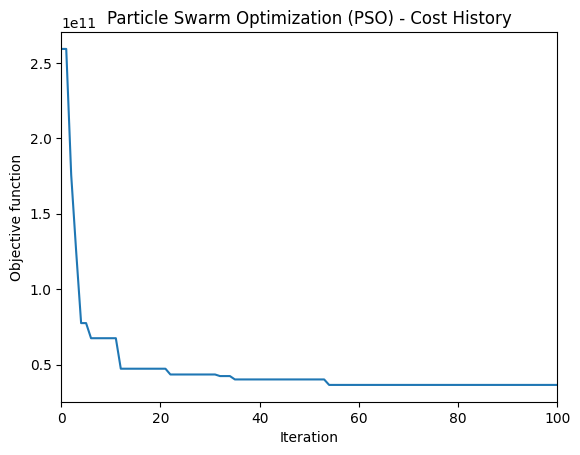

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 211806328053.34277


In [53]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

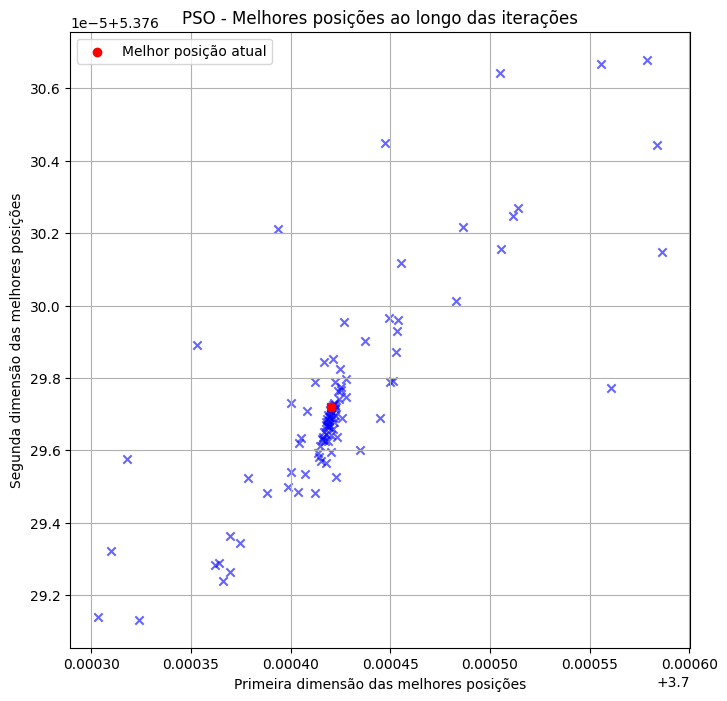

In [54]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()